In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
raven = pl.read_csv("raven_annotations.csv")

In [3]:
raven

filename,begin_time_s,end_time_s,id,label,timestamp_s
str,f64,f64,str,str,f64
"""BLUE-6-CAPLE_20180606_070000.w…",1.227414,3.657139,"""moch""","""mouchi""",0.0
"""BLUE-6-CAPLE_20180606_070000.w…",0.074323,1.14505,"""moch""","""mouchi""",0.0
"""BLUE-6-CAPLE_20180606_070000.w…",5.040054,6.632416,"""stja""","""stejay""",5.0
"""BLUE-6-CAPLE_20180606_070000.w…",9.405324,10.832959,"""stja""","""stejay""",10.0
"""BLUE-6-CAPLE_20180606_070000.w…",90.914068,92.198867,"""rbnu""","""rebnut""",90.0
…,…,…,…,…,…
"""RED-4-CAPL_20190624_093000.wav""",293.455127,294.813289,"""gcki""","""gockin""",290.0
"""RED-4-CAPL_20190624_093000.wav""",298.820286,299.999977,"""stja""","""stejay""",295.0
"""RED-4-CAPL_20190624_093000.wav""",298.116952,299.790402,"""gcki""","""gockin""",295.0


In [4]:
outputs = pl.read_parquet('../outputs_all/inference_custom.parquet')

In [5]:
outputs_2018_2019 = outputs.filter(
    (pl.col('filename').str.starts_with('2018/')) | 
    (pl.col('filename').str.starts_with('2019/'))
)

In [6]:
outputs_2018_2019 = outputs_2018_2019.with_columns(
    (
        outputs_2018_2019['filename']
        .str.splitn('/', 2)
        .struct.rename_fields(['year', 'filename'])
        .alias('fields')
        .to_frame()
        .unnest('fields')
    )
)

In [7]:
outputs_2018_2019 = outputs_2018_2019.with_columns(
    pl.col('label').str.head(6).alias('label_sp')
)

In [8]:
merged = outputs_2018_2019.join(raven, 
                                left_on=['filename', 'label_sp', 'timestamp_s'], 
                                right_on=['filename', 'label', 'timestamp_s'], 
                                how='inner')

In [14]:
merged_dup = merged.unique(subset=['filename', 'timestamp_s', 'label'])

In [15]:
merged_dup

filename,timestamp_s,label,logit,year,label_sp,begin_time_s,end_time_s,id
str,f64,str,f64,str,str,f64,f64,str
"""BROWN-9-CAPL_20190621_093000.w…",180.0,"""gockin_song""",-5.15,"""2019""","""gockin""",181.657152,183.647388,"""gcki_c_song"""
"""BLKFR-10-CPL_20190628_093000.w…",70.0,"""herthr_song""",-6.04,"""2019""","""herthr""",70.056942,71.30534,"""heth_c_song"""
"""BLUE-6-CAPLE_20180605_183000.w…",535.0,"""amerob_song""",-6.44,"""2018""","""amerob""",538.541474,539.80819,"""amro"""
"""GREEN-5-CAPL_20190614_083000.w…",135.0,"""herthr_call""",-6.93,"""2019""","""herthr""",135.634373,137.718982,"""heth_c_song"""
"""WHITE-2-CAPL_20190611_093000.w…",150.0,"""gockin_call""",-0.46,"""2019""","""gockin""",151.404935,152.451047,"""gcki"""
…,…,…,…,…,…,…,…,…
"""ORANGE-7-CAP_20190614_093000.w…",250.0,"""naswar_song""",-6.93,"""2019""","""naswar""",250.684406,252.306368,"""nawa"""
"""CLEAR-1-CAPL_20190609_093000.w…",25.0,"""mouchi_song""",-0.51,"""2019""","""mouchi""",28.351429,29.718217,"""moch_c_song"""
"""ORANGE-7-CAP_20190606_093000.w…",295.0,"""westan_call""",-6.27,"""2019""","""westan""",296.614276,299.295811,"""weta"""


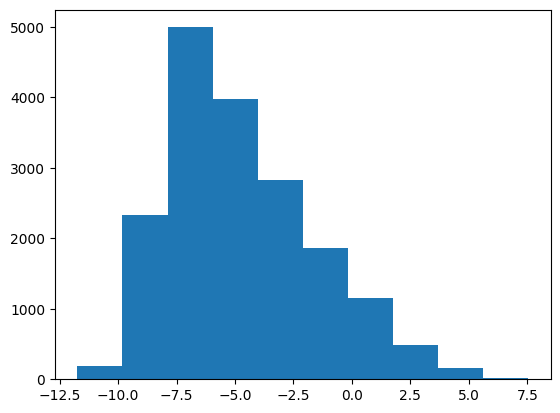

In [10]:
# merged['logit'].hist()
plt.hist(merged['logit'])
plt.show()